In [1]:
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
#importing all the dependencies

In [2]:
content = plt.imread('content.jpg')
style = plt.imread('style.jpg')

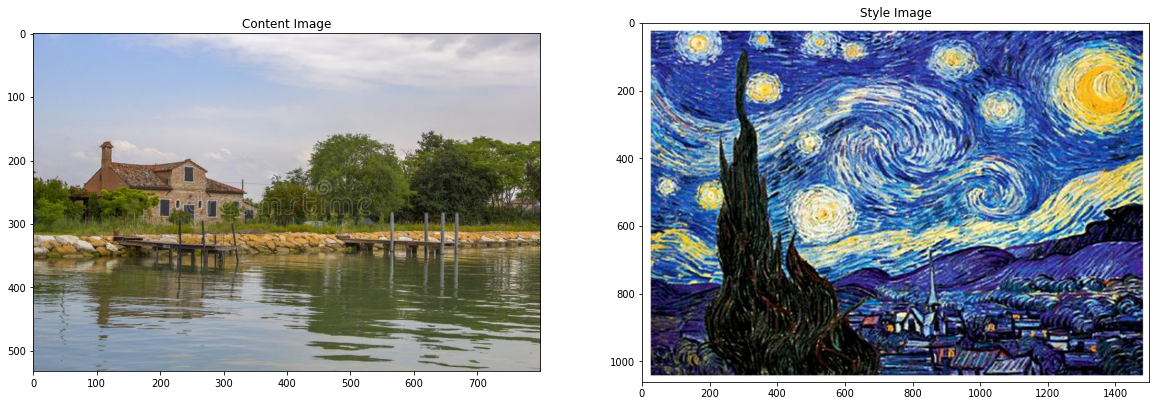

In [3]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(content)
ax1.set_title('Content Image')
ax2.imshow(style)
ax2.set_title('Style Image')
plt.show()

In [4]:
def load_pic(image):#loading the image and converting it into float data type
    img = plt.imread(image)
    img = tf.image.convert_image_dtype(img,tf.float32)
    img = tf.image.resize(img, [400,400])
    img = img[tf.newaxis, :]
    return img

In [5]:
content = load_pic('content.jpg')
style = load_pic('style.jpg')

In [6]:
content.shape, style.shape

(TensorShape([1, 400, 400, 3]), TensorShape([1, 400, 400, 3]))

In [7]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
vgg.trainable = False #importing vgg19 as a non trainable model

In [8]:
for layer in vgg.layers:
  print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [9]:
content_layers = ['block4_conv2'] #content layer
style_layers = ['block1_conv1','block2_conv1','block3_conv1','block4_conv1','block5_conv1']
#style layers

In [10]:
n_content = len(content_layers)
n_style = len(style_layers)

In [11]:
def mini_model(layer_names, model): #creating mini model to extract features while performing forward pass
  outputs = [model.get_layer(name).output for name in layer_names]
  model = Model([vgg.input], outputs)
  return model

In [12]:
def gram_matrix(tensor): #defining a gram matrix
  temp = tensor
  temp = tf.squeeze(temp)
  fun = tf.reshape(temp, [temp.shape[2], temp.shape[0]*temp.shape[1]])
  result = tf.matmul(temp, temp, transpose_b=True)
  gram = tf.expand_dims(result, axis=0)
  return gram

In [13]:
class Custom_Style_Model(tf.keras.models.Model): #returns the content and style features from respective images
  def __init__(self, style_layers, content_layers):
    super(Custom_Style_Model, self).__init__()
    self.vgg =  mini_model(style_layers + content_layers, vgg)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    inputs = inputs*255.0
    preprocessed_input = preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])
    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]
    content_dict = {content_name:value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content':content_dict, 'style':style_dict}

In [14]:
extractor = Custom_Style_Model(style_layers, content_layers)
style_targets = extractor(style)['style'] #loading the extracted values into variables
content_targets = extractor(content)['content']

In [15]:
opt = tf.optimizers.Adam(learning_rate=0.02) #defining the optimizer

In [16]:
style_weight=80 #hyperparameters for the composite model
content_weight=20
style_weights = {'block1_conv1': 1.,
                 'block2_conv1': 0.8,
                 'block3_conv1': 0.2,
                 'block4_conv1': 0.1,
                 'block5_conv1': 0.1}

In [17]:
def total_loss(outputs):#the total loss
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([style_weights[name]*tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                           for name in style_outputs.keys()])
    # Normalize
    style_loss *= style_weight / n_style

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    # Normalize
    content_loss *= content_weight / n_content
    loss = style_loss + content_loss
    return loss

In [18]:
def train_step(image):
  with tf.GradientTape() as tape:
    # Extract the features
    outputs = extractor(image)
    # Calculate the loss
    loss = total_loss(outputs)
  # Determine the gradients of the loss function w.r.t the image pixels
  grad = tape.gradient(loss, image)
  # Update the pixels
  opt.apply_gradients([(grad, image)])
  # Clip the pixel values that fall outside the range of [0,1]
  image.assign(tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0))

In [19]:
target_image = tf.Variable(content)

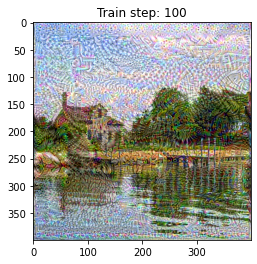

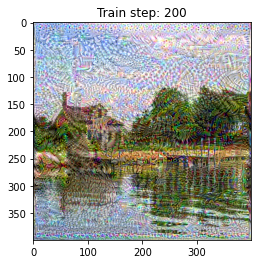

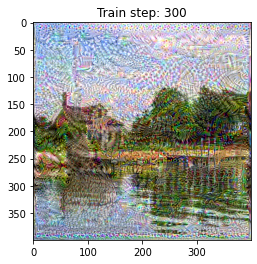

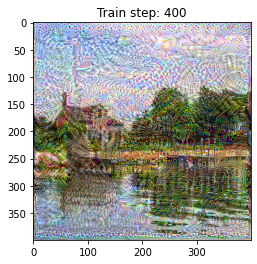

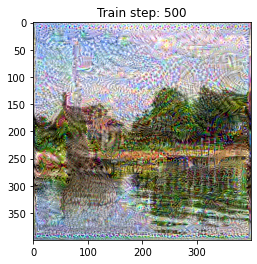

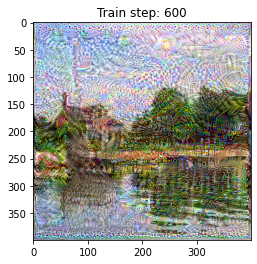

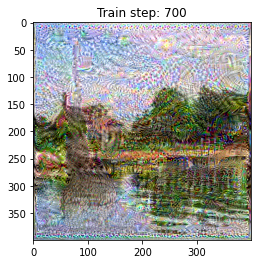

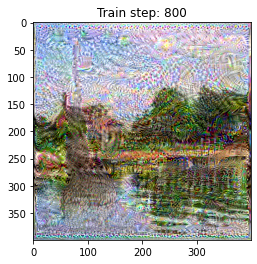

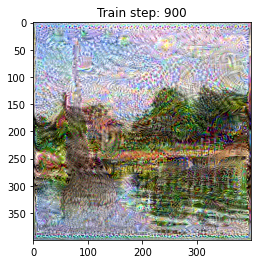

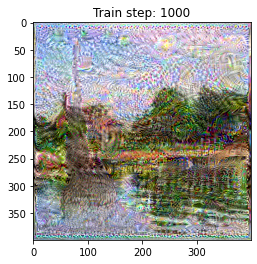

In [20]:
epochs = 10
steps_per_epoch = 100
#training
step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(target_image)
  plt.imshow(np.squeeze(target_image.read_value(), 0))
  plt.title("Train step: {}".format(step))
  plt.show()

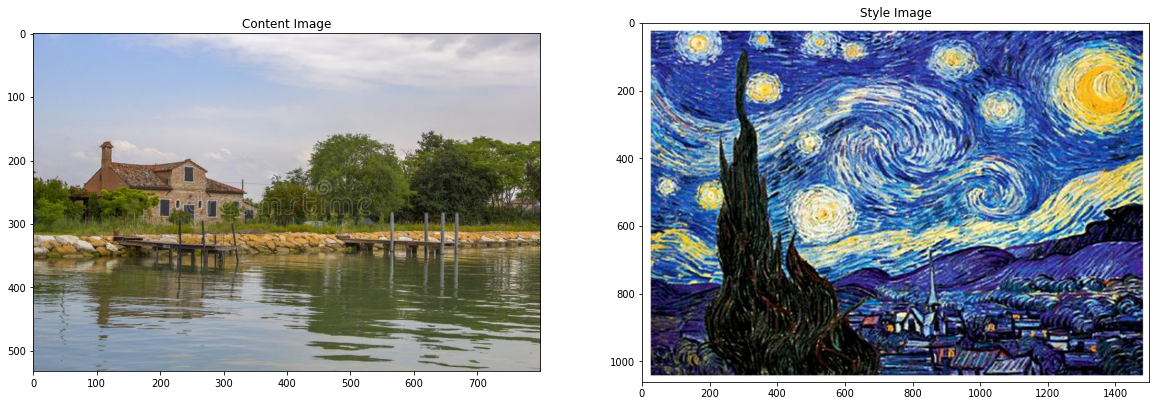

In [21]:
content = plt.imread('content.jpg')
style = plt.imread('style.jpg')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(content)
ax1.set_title('Content Image')
ax2.imshow(style)
ax2.set_title('Style Image')
plt.show()

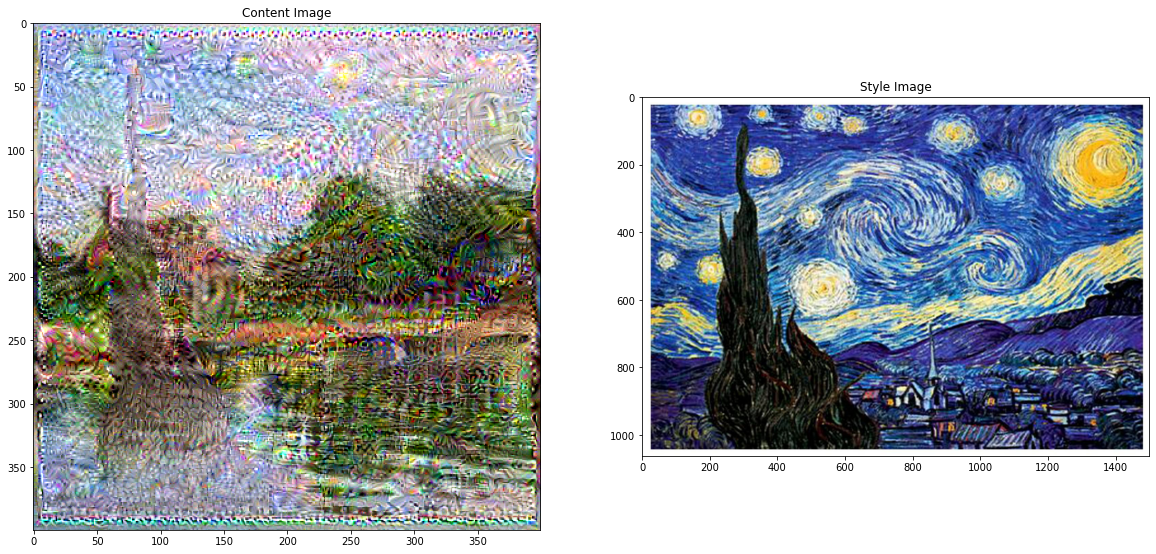

In [22]:
style = plt.imread('style.jpg')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(np.squeeze(target_image.read_value(), 0))
ax1.set_title('Content Image')
ax2.imshow(style)
ax2.set_title('Style Image')
plt.show()